In [97]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from backtesting import Backtest, Strategy


nifty_50_tickers = [
    "SUNPHARMA.NS", "ZOMATO.NS", "M&M.NS", "HCLTECH.NS", "TRENT.NS",
    "DIVISLAB.NS", "INFY.NS", "TECHM.NS", "BHARTIARTL.NS", "DIXON.NS", 
    "ICICIBANK.NS", "ITC.NS", "TCS.NS", "SBIN.NS",
    "NTPC.NS", "TATAMOTORS.NS", "POWERGRID.NS", "BAJAJ-AUTO.NS"
]


nifty_data = yf.download("^NSEI")  
nifty_close = nifty_data['Close']

data = yf.download(nifty_50_tickers, start="2023-01-02", end="2025-01-16")['Adj Close']


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  18 of 18 completed


In [98]:
total_allocation_per_stock = 0.03
weights = np.full(len(nifty_50_tickers), total_allocation_per_stock)


#if weights.sum() > 1.0:
#    weights /= weights.sum()


daily_returns = data.pct_change().dropna()
portfolio_returns = (daily_returns * weights).sum(axis=1)

In [99]:

initial_investment = 1000000000
portfolio_value = initial_investment * (1 + portfolio_returns).cumprod()


bt_data = pd.DataFrame({
    'Open': portfolio_value,
    'High': portfolio_value,
    'Low': portfolio_value,
    'Close': portfolio_value,
}, index=portfolio_returns.index)


class BuyAndHoldPortfolioStrategy(Strategy):
    def init(self):
        pass
    
    def next(self):
        if len(self.trades) == 0:
            self.buy()

bt = Backtest(bt_data, BuyAndHoldPortfolioStrategy, cash=1000000000, commission=0.002)
stats = bt.run()
print(stats)


Start                     2023-01-03 00:00:00
End                       2025-01-15 00:00:00
Duration                    743 days 00:00:00
Exposure Time [%]                   99.600798
Equity Final [$]            1524633185.390481
Equity Peak [$]             1593919915.190845
Return [%]                          52.463319
Buy & Hold Return [%]               52.009797
Return (Ann.) [%]                   23.632054
Volatility (Ann.) [%]                8.565565
Sharpe Ratio                          2.75896
Sortino Ratio                        5.342354
Calmar Ratio                         4.619596
Max. Drawdown [%]                    -5.11561
Avg. Drawdown [%]                   -0.687048
Max. Drawdown Duration      111 days 00:00:00
Avg. Drawdown Duration       11 days 00:00:00
# Trades                                    1
Win Rate [%]                            100.0
Best Trade [%]                      52.629441
Worst Trade [%]                     52.629441
Avg. Trade [%]                    

C:\Users\User\AppData\Local\Temp\ipykernel_15672\2614541103.py:21: UserWarning: Some prices are larger than initial cash value. Note that fractional trading is not supported. If you want to trade Bitcoin, increase initial cash, or trade μBTC or satoshis instead (GH-134).
  bt = Backtest(bt_data, BuyAndHoldPortfolioStrategy, cash=1000000000, commission=0.002)


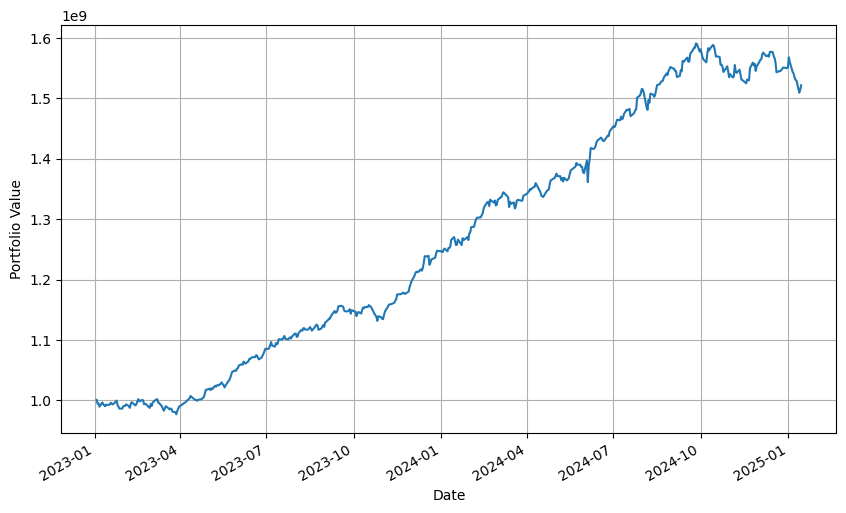

In [100]:
plt.figure(figsize=(10, 6))
portfolio_value.plot()

plt.xlabel("Date")
plt.ylabel("Portfolio Value")
plt.grid(True)
plt.show()

C:\Users\User\AppData\Local\Temp\ipykernel_15672\607991925.py:1: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  aligned_nifty = nifty_close.reindex(portfolio_value.index).fillna(method='ffill')


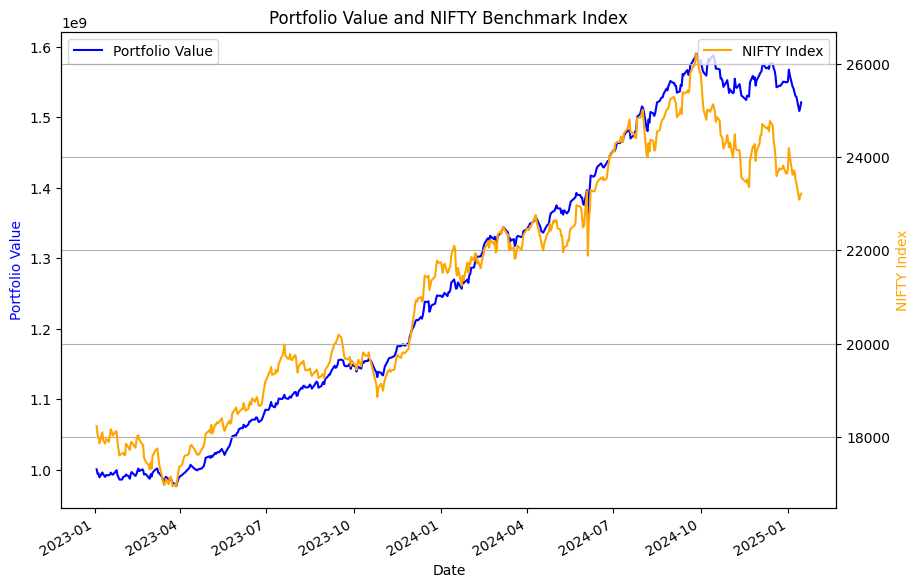

In [101]:
aligned_nifty = nifty_close.reindex(portfolio_value.index).fillna(method='ffill')

plt.figure(figsize=(10, 7))
portfolio_value.plot(label="Portfolio Value", color="blue")

ax = plt.gca()  
ax2 = ax.twinx() 
aligned_nifty.plot(ax=ax2, label="NIFTY Index", color="orange", linestyle="-")

ax.set_xlabel("Date")
ax.set_ylabel("Portfolio Value", color="blue")
ax2.set_ylabel("NIFTY Index", color="orange")

plt.grid(True)
ax.legend(loc="upper left")
ax2.legend(loc="upper right")

plt.title("Portfolio Value and NIFTY Benchmark Index")
plt.show()


In [102]:
rolling_max = portfolio_value.cummax()
drawdown = (portfolio_value - rolling_max) / rolling_max

nifty_peak = nifty_close.cummax()
nifty_drawdown = (nifty_close - nifty_peak) / nifty_peak

C:\Users\User\AppData\Local\Temp\ipykernel_15672\1253102767.py:1: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  aligned_nifty_drawdown = nifty_drawdown.reindex(drawdown.index).fillna(method='ffill')


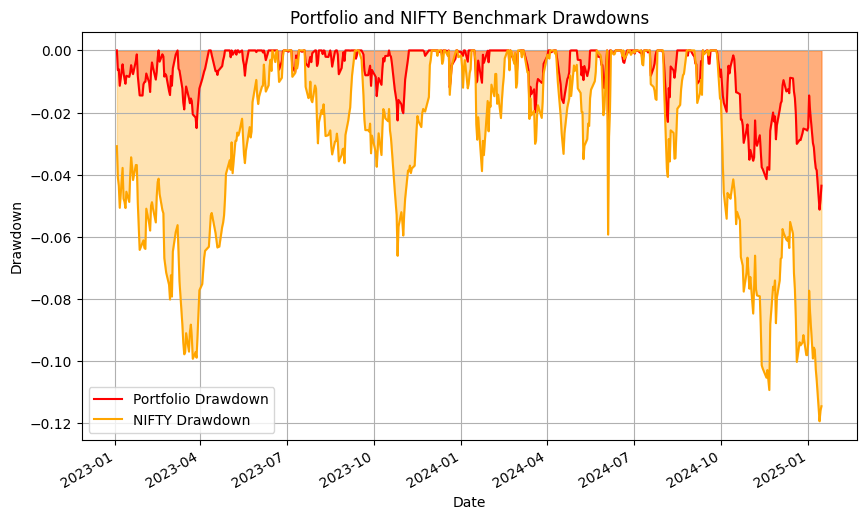

In [103]:
aligned_nifty_drawdown = nifty_drawdown.reindex(drawdown.index).fillna(method='ffill')

plt.figure(figsize=(10, 6))
drawdown.plot(color="red", label="Portfolio Drawdown")
plt.fill_between(drawdown.index, drawdown, 0, color="red", alpha=0.3)

aligned_nifty_drawdown.plot(color="orange", linestyle="-", label="NIFTY Drawdown")
plt.fill_between(
    aligned_nifty_drawdown.index, 
    aligned_nifty_drawdown, 
    0, 
    color="orange", 
    alpha=0.3
)

plt.title("Portfolio and NIFTY Benchmark Drawdowns")
plt.xlabel("Date")
plt.ylabel("Drawdown")
plt.grid(True)


plt.legend()
plt.show()

In [104]:
monthly_returns = portfolio_returns.resample('M').apply(lambda x: (1 + x).prod() - 1)
yearly_returns = portfolio_returns.resample('Y').apply(lambda x: (1 + x).prod() - 1)


monthly_returns_table = monthly_returns.to_frame(name="Monthly Return")
monthly_returns_table['Year'] = monthly_returns_table.index.year
monthly_returns_table['Month'] = monthly_returns_table.index.month

monthly_returns_pivot = monthly_returns_table.pivot(index='Year', columns='Month', values='Monthly Return')


monthly_returns_pivot.columns = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 
                                 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']


monthly_returns_pivot['Year End Return'] = yearly_returns.values

Monthly Returns for Each Year with Year-End Return:
           Jan       Feb       Mar       Apr       May       Jun       Jul  \
Year                                                                         
2023 -0.010025 -0.002430  0.002149  0.027755  0.034634  0.031426  0.023040   
2024  0.023463  0.037177  0.011158  0.021837  0.005984  0.051785  0.047197   
2025 -0.018232       NaN       NaN       NaN       NaN       NaN       NaN   

           Aug       Sep       Oct       Nov       Dec  Year End Return  
Year                                                                     
2023  0.009983  0.024678 -0.012252  0.050014  0.046292         0.247103  
2024  0.023857  0.016479 -0.026954  0.011536 -0.001773         0.242665  
2025       NaN       NaN       NaN       NaN       NaN        -0.018232  


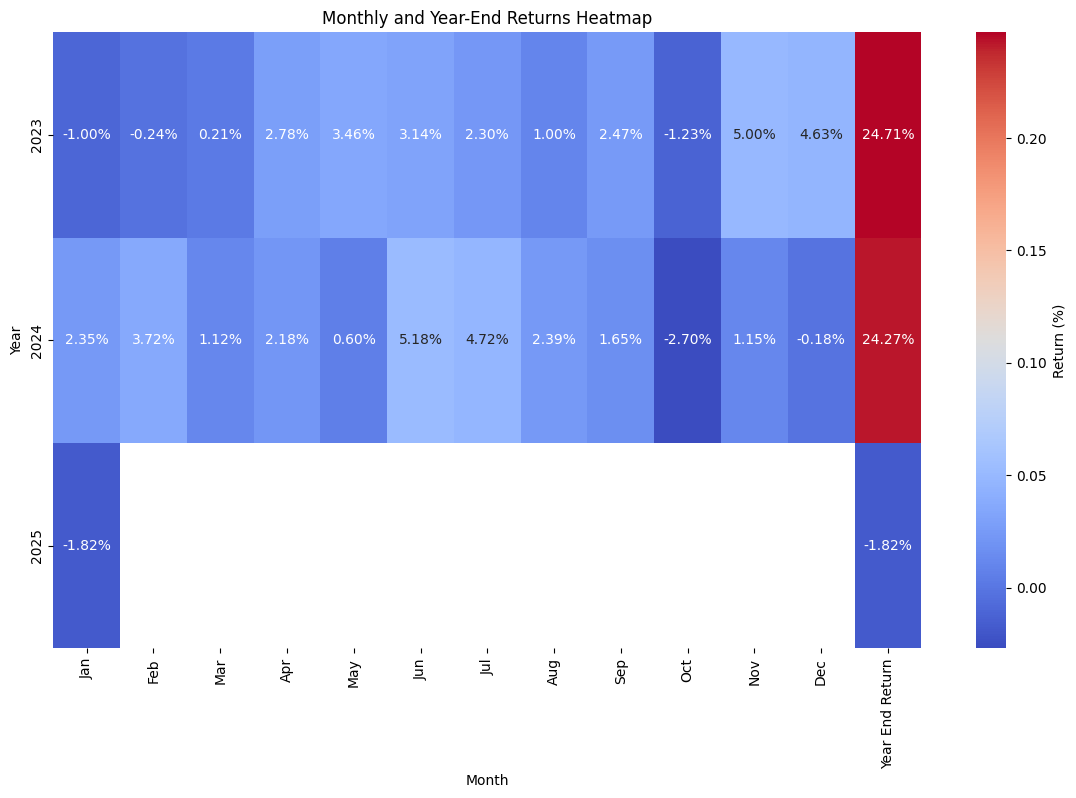

In [105]:
print("Monthly Returns for Each Year with Year-End Return:")
print(monthly_returns_pivot)

import seaborn as sns

plt.figure(figsize=(14, 8))
sns.heatmap(monthly_returns_pivot, annot=True, fmt=".2%", cmap="coolwarm", cbar_kws={'label': 'Return (%)'})
plt.title("Monthly and Year-End Returns Heatmap")
plt.xlabel("Month")
plt.ylabel("Year")
plt.show()

In [106]:
class BuyAndHoldPortfolioStrategy(Strategy):
    def init(self):
        self.has_bought = {ticker: False for ticker in nifty_50_tickers}

    def next(self):
        for i, ticker in enumerate(nifty_50_tickers):
            if not self.has_bought[ticker]:
                
                self.buy(size=weights[i] * initial_investment / self.data.Close)
                self.has_bought[ticker] = True


entry_points = []

for ticker in nifty_50_tickers:
    stock_data = data[ticker].dropna()
    entry_price = stock_data.iloc[0]
    entry_date = stock_data.index[0]
    entry_points.append((ticker, entry_date, entry_price))

entry_points_df = pd.DataFrame(entry_points, columns=["Ticker", "Entry Date", "Entry Price"])

print(entry_points_df)


           Ticker Entry Date  Entry Price
0    SUNPHARMA.NS 2023-01-02   977.393738
1       ZOMATO.NS 2023-01-02    60.299999
2          M&M.NS 2023-01-02  1227.834595
3      HCLTECH.NS 2023-01-02   960.256775
4        TRENT.NS 2023-01-02  1339.260742
5     DIVISLAB.NS 2023-01-02  3298.538086
6         INFY.NS 2023-01-02  1447.292603
7        TECHM.NS 2023-01-02   947.016724
8   BHARTIARTL.NS 2023-01-02   805.292542
9        DIXON.NS 2023-01-02  3893.497070
10   ICICIBANK.NS 2023-01-02   880.165771
11         ITC.NS 2023-01-02   315.368134
12         TCS.NS 2023-01-02  3167.366211
13        SBIN.NS 2023-01-02   590.625610
14        NTPC.NS 2023-01-02   156.170151
15  TATAMOTORS.NS 2023-01-02   392.362518
16   POWERGRID.NS 2023-01-02   145.792969
17  BAJAJ-AUTO.NS 2023-01-02  3439.902588


In [107]:
investment_per_stock = initial_investment * weights

first_prices = data.iloc[0]

quantities_traded = (investment_per_stock / first_prices).astype(int)
investment_values = quantities_traded * first_prices

investment_summary = pd.DataFrame({
    'Ticker': nifty_50_tickers,
    'Entry Price (INR)': first_prices.values,
    'Quantity Traded': quantities_traded.values,
    'Investment Value (INR)': investment_values.values
})


print(investment_summary)

           Ticker  Entry Price (INR)  Quantity Traded  Investment Value (INR)
0    SUNPHARMA.NS        3439.902588             8721            2.999939e+07
1       ZOMATO.NS         805.292542            37253            2.999956e+07
2          M&M.NS        3298.538086             9094            2.999691e+07
3      HCLTECH.NS        3893.497070             7705            2.999939e+07
4        TRENT.NS         960.256775            31241            2.999938e+07
5     DIVISLAB.NS         880.165771            34084            2.999957e+07
6         INFY.NS        1447.292603            20728            2.999948e+07
7        TECHM.NS         315.368134            95126            2.999971e+07
8   BHARTIARTL.NS        1227.834595            24433            2.999968e+07
9        DIXON.NS         156.170151           192098            2.999997e+07
10   ICICIBANK.NS         145.792969           205771            2.999996e+07
11         ITC.NS         590.625610            50793           

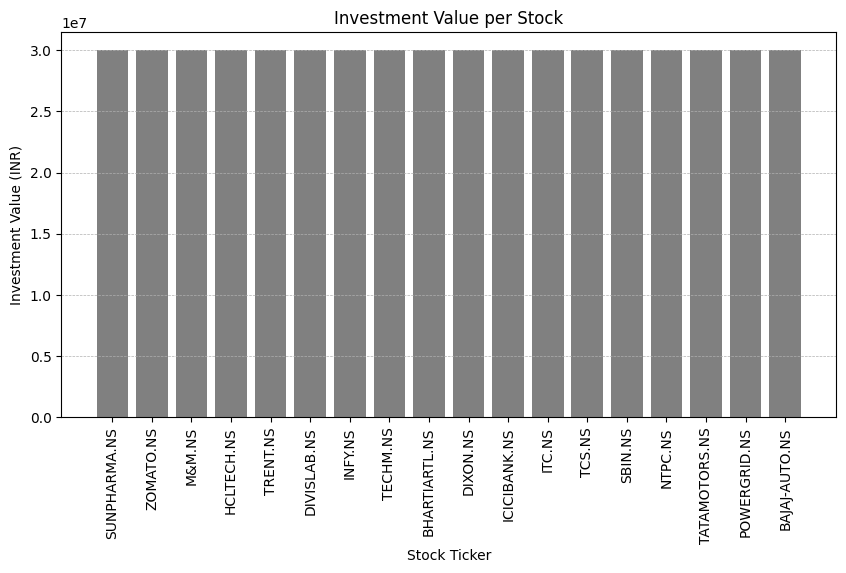

In [108]:
plt.figure(figsize=(10, 5))
plt.bar(investment_summary['Ticker'], investment_summary['Investment Value (INR)'], color='grey')
plt.title("Investment Value per Stock")
plt.xlabel("Stock Ticker")
plt.ylabel("Investment Value (INR)")
plt.xticks(rotation=90)
plt.grid(axis='y', linestyle='--', linewidth=0.5)
plt.show()

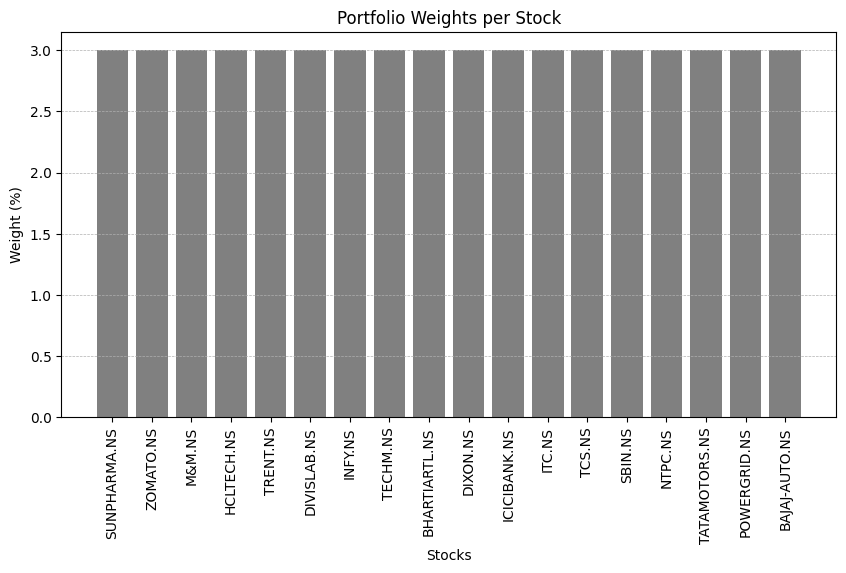

In [109]:
plt.figure(figsize=(10, 5))
plt.bar(nifty_50_tickers, weights * 100, color='grey')
plt.title("Portfolio Weights per Stock")
plt.xlabel("Stocks")
plt.ylabel("Weight (%)")
plt.xticks(rotation=90)
plt.grid(axis='y', linestyle='--', linewidth=0.5)
plt.show()


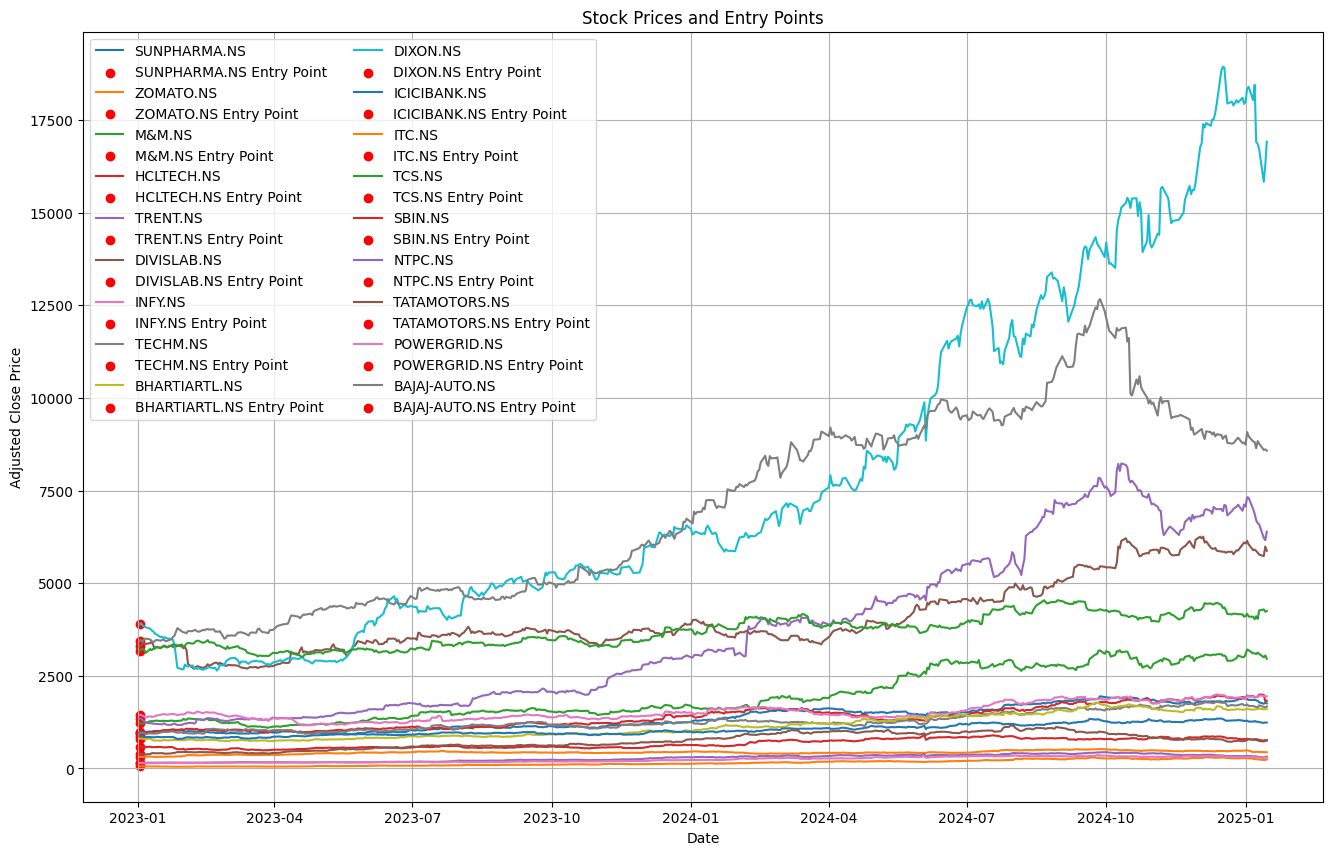

In [110]:
plt.figure(figsize=(16, 10))
for ticker in nifty_50_tickers:
    plt.plot(data[ticker], label=ticker)
    plt.scatter(entry_points_df.loc[entry_points_df['Ticker'] == ticker, 'Entry Date'],
                entry_points_df.loc[entry_points_df['Ticker'] == ticker, 'Entry Price'], 
                color='red', marker='o', label=f"{ticker} Entry Point")
    


plt.title("Stock Prices and Entry Points")
plt.xlabel("Date")
plt.ylabel("Adjusted Close Price")
plt.legend(loc='best', ncol=2)
plt.grid(True)
plt.show()


##### reference:
##### 1. https://www.niftyindices.com/indices/equity/strategy-indices/nifty200-momentum-30
##### 2. https://www.niftyindices.com/indices/equity/strategy-indices/nifty-50-value-20